In [67]:
import numpy as np
import matplotlib.pylab as plt
import emcee
import corner

# % matplotlib inline

In [68]:
sparc_master = np.genfromtxt("/Users/mkorsaga/sparc/galaxy_parameters.txt", dtype=None)

id_ngc3198 = 53

<ipython-input-68-2adbf1eac1bf>:1: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  sparc_master = np.genfromtxt("/Users/mkorsaga/sparc/galaxy_parameters.txt", dtype=None)


## Utility functions

In [69]:
# constants
G, H = 4.301e-9, 67.6
Dc = 200.

def c(M): # from Dutton & Maccio' (2014) -- with c_200
    return 10.**(0.905 - 0.101 * (np.log10(M*H/100.)-12))

def fc(x):
    return np.log(1+x)-x/(1+x)

def Vvir(Mh):
    return np.sqrt((Dc*(H)**2/2)**(1./3.) * (G*Mh)**(2./3.))

def Mvir(Vh):
    return np.sqrt(2./Dc)/G/H * Vh**3

def Rvir(Mh):
    rho_c = 3. * (H)**2 / (8. * np.pi * G)
    rho_hat = 4. / 3. * np.pi * Dc * rho_c
    return 1e3 * np.power(Mh / rho_hat, 1./3.)

## Likelihood, prior and posterior

In [70]:
# circular velocity of NFW halo
def vc(R, Mh, cc):
    return np.sqrt(Vvir(Mh)**2*Rvir(Mh)/R*fc(cc*R/Rvir(Mh))/fc(cc))

# log-likelihood
def lnlike(theta, vobs, e_vobs, vgas, vdisc, vbulge, rad):
    # parameters: logMh, logc, logM/L
    logMh, logc, lml = theta
    vbar = np.sqrt(vgas**2 + (10**lml) * vdisc**2 + 1.4*(10**lml) * vbulge**2)
    v_mod = np.sqrt(vc(rad, 10**logMh, 10**logc)**2 + vbar**2)
    chisq = np.sum(((v_mod-vobs)**2/e_vobs**2))
    
    return -chisq/(len(vobs)-3)

# log-prior: flat on Mh and M/L, Gaussian on c
def lnprior(theta):  # gaussian prior on the c-M relation from Dutton & Maccio' (2014) -- with scatter 0.11 dex
    logMh, logc, lml = theta
    if 0 < logMh < 20 and -2 < lml < 1.3:
        cmean, s_cM = c(10**logMh), 0.11
        return -0.5*(logc-np.log10(cmean))**2/s_cM**2-np.log(np.sqrt(2*np.pi)*s_cM)
    return -np.inf  

# log-probability
def lnprob(theta, vobs, e_vobs, vgas, vdisc, vbulge, rad):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, vobs, e_vobs, vgas, vdisc, vbulge, rad)

## Running the MCMC

In [71]:
d = np.genfromtxt("NGC5055_rotmod.dat")

rad = d[:, 0]
vobs, e_vobs = d[:, 1], d[:, 2]
vgas, vdisc, vbulge = d[:, 3], d[:, 4], d[:, 5]

dirin="output/"

# MCMC analysis
# using 20 chains (walkers) and evaluating 4000 steps
ndim, nwalkers, nstep = 3, 20, 4000

# initial guess position
pos = [(12,1.0,-0.3) + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# run the MCMC sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(vobs, e_vobs, vgas, vdisc, vbulge, rad))
sampler.run_mcmc(pos, nstep)

# cut initial steps (burn-in phase)
burnin = 500
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
samples[:,2] = 10**samples[:,2]  # transform to M/L

# get max-probability model
lnprobs = sampler.lnprobability[:, burnin:].reshape(-1)
max_prob = np.copy(samples[np.argmax(lnprobs),:])

0.322151951956869


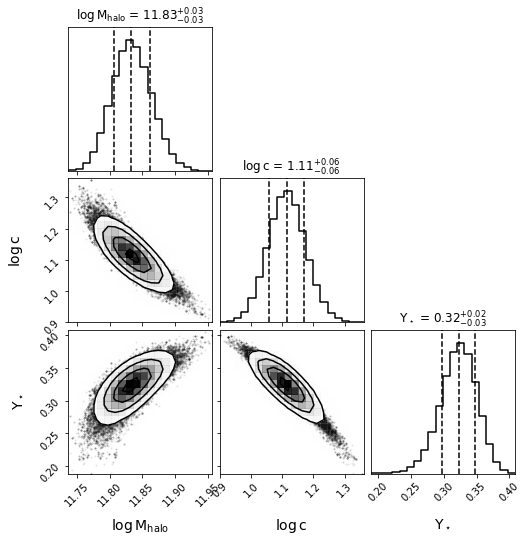

In [72]:
corner.corner(samples, labels=[r"$\rm\log\,M_{halo}$", r"$\rm\log\,c$", r"$\Upsilon_\star$"],
              quantiles=[.16,.50,.84], show_titles=True, smooth=1., smooth1d=1., label_kwargs={'fontsize':14});
print(np.mean(samples[:,2]))
# plt.savefig(dirin+"NGC5055_sample.png")

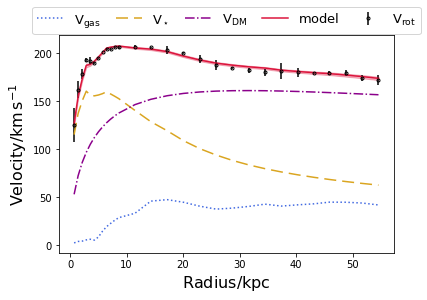

In [73]:
fig, ax = plt.subplots()

# Vstar & VDM of the best model
vstar = np.sqrt(max_prob[2] * vdisc**2 + 1.4*max_prob[2] * vbulge**2)
vdm = vc(rad, 10**max_prob[0], 10**max_prob[1])
# array of curves for each sampled model
vms = np.array([np.sqrt(samples[k,2]*vdisc**2 + 1.4*samples[k,2]*vbulge**2 +
                        vgas**2 + 
                        vc(rad, 10**samples[k,0], 10**samples[k,1])**2) 
                for k in range(len(samples))])

ax.errorbar(rad, vobs, yerr=e_vobs, fmt='.', mfc='none', label=r"$\rm V_{rot}$", c='k')
ax.plot(rad, vgas, color='royalblue', ls=":", label=r"$\rm V_{gas}$")
ax.plot(rad, vstar, color='goldenrod', dashes=[8, 4], label=r"$\rm V_\star$")
ax.plot(rad, vdm, c='darkmagenta', ls="-.", label=r"$\rm V_{DM}$")
ax.plot(rad, np.sqrt(vstar**2 + vgas**2 + vdm**2), c='crimson', label=r"$\rm model$")
ax.fill_between(rad, np.median(vms,axis=0)+np.std(vms,axis=0), np.median(vms,axis=0)-np.std(vms,axis=0),
                color='crimson', alpha=0.3)
ax.set_xlabel(r"$\rm Radius/kpc$", fontsize=16);
ax.set_ylabel(r"$\rm Velocity/km\,s^{-1}$", fontsize=16);
ax.legend(bbox_to_anchor=(-0.1, 1.06, 1.2, .102), fontsize=13, mode="expand", ncol=5)
# plt.savefig(dirin+"NGC5055_massmodel.png")

In [74]:
c

<function __main__.c(M)>